# DataONE Contributors

Examine the solr index to determine the number of contributors to content exposed by DataONE. The count provided here is likely higher than the actual number of contributors because the indexing process only performs minimal pre-processing of names added to the index. For example, in some cases names appear with both ASCII and Unicode variants and are treated as separate.

In [1]:
import requests
import json
import pprint
from datetime import datetime
import dateutil

SOLR_TIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"

T_NOW = datetime.utcnow()
T_START = datetime(2012,7,1)


In [2]:
def getContributors(t_start=None, t_end=None):
    url = "https://cn.dataone.org/cn/v2/query/solr/"
    params = {
        "q":"*:*",
        "facet":"on",
        "rows":"0",
        "facet.limit":"-1",
        "facet.field":"investigator",
        "wt":"json",
             }
    dq = None
    if t_start is not None:
        st = f"{t_start:{SOLR_TIME_FORMAT}}"
        if t_end is None:
            dq = f"dateUploaded:[\"{st}\" TO \"{T_NOW}\"]"
        else:
            dq = f"dateUploaded:[\"{st}\" TO \"{t_end:{SOLR_TIME_FORMAT}}\"]"
    else:
        et = f"{t_end:{SOLR_TIME_FORMAT}}"
        dq = f"dateUploaded:[* TO \"{et}\"]"
    if dq is not None:
        params["q"] = dq
    response = requests.get(url, params=params)
    data = json.loads(response.text)
    investigators = data["facet_counts"]["facet_fields"]["investigator"]
    names = []
    counts = []
    for i in range(0, len(investigators), 2):
        n = investigators[i+1]
        if n > 0:
            names.append(investigators[i])
            counts.append(investigators[i+1])
    return names, counts



In [3]:
c_date = T_START
name_count = []
columns = ["date","contributors"]
print(",".join(columns))
while c_date < T_NOW:
    names, counts = getContributors(t_end = c_date)
    entry = (c_date, len(names))
    print(f"{entry[0]:%Y-%m-%d},{entry[1]}")
    name_count.append(entry)
    c_date = c_date + dateutil.relativedelta.relativedelta(months=+1)


date,contributors
2012-07-01,10676
2012-08-01,11835
2012-09-01,12310
2012-10-01,12722
2012-11-01,13501
2012-12-01,14083
2013-01-01,14532
2013-02-01,15344
2013-03-01,16189
2013-04-01,16865
2013-05-01,17419
2013-06-01,18375
2013-07-01,19018
2013-08-01,19658
2013-09-01,20428
2013-10-01,21421
2013-11-01,22167
2013-12-01,22831
2014-01-01,23401
2014-02-01,24338
2014-03-01,25228
2014-04-01,26032
2014-05-01,26900
2014-06-01,27628
2014-07-01,28565
2014-08-01,29560
2014-09-01,30231
2014-10-01,31694
2014-11-01,32790
2014-12-01,34659
2015-01-01,36014
2015-02-01,37110
2015-03-01,38396
2015-04-01,39941
2015-05-01,41454
2015-06-01,42865
2015-07-01,44358
2015-08-01,45758
2015-09-01,47004
2015-10-01,48472
2015-11-01,49924
2015-12-01,51176
2016-01-01,52655
2016-02-01,54005
2016-03-01,55489
2016-04-01,58751
2016-05-01,60908
2016-06-01,62549
2016-07-01,63852
2016-08-01,65059
2016-09-01,66838
2016-10-01,68334
2016-11-01,71910
2016-12-01,73637
2017-01-01,78433
2017-02-01,80177
2017-03-01,81667
2017-04-01,83

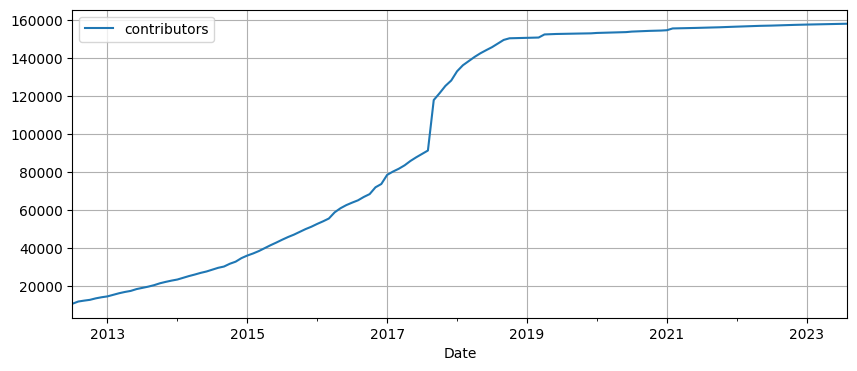

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
data_frame = pd.DataFrame(name_count, columns=columns)
data_frame.set_index('date', inplace=True)

plot = data_frame.plot(figsize=(10,4))
plot.set_xlabel("Date")
plot.grid(True)